In [1]:
#data processing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

In [2]:
# Machine learning package
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

/Users/hetufeng/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Read File

In [3]:
stackoverflow = pd.read_csv("survey_results_public.csv")

In [4]:
stackoverflow.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource',
       'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor',
       'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode',
       'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney',
       'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz',
       'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc',
       'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan',
       'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev',
       'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat',
       'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife'

## General Data preprosessing

### Drop useless columns

In [5]:
stackoverflow.drop(['Hobbyist','OpenSourcer'], axis = 1, inplace = True)
stackoverflow.drop(['Respondent'],axis = 1, inplace = True)
#stackoverflow.drop(stackoverflow.iloc[:,22:25], axis = 1, inplace = True)
stackoverflow.drop(['CodeRev', 'CodeRevHrs', 'UnitTests', 'PurchaseHow','PurchaseWhat',
                    'Containers','BlockchainOrg', 'BlockchainIs','BetterLife','ITperson','OffOn','SocialMedia',
                    'Extraversion','ScreenName','SOVisit1st',
                    'EntTeams','WelcomeChange','SurveyLength','SurveyEase'], axis = 1, inplace = True)
stackoverflow.drop(['Trans','Sexuality','Ethnicity'], axis = 1, inplace = True)
stackoverflow.drop(['CurrencySymbol','CurrencyDesc','CompTotal', 'CompFreq'], axis = 1, inplace = True)

stackoverflow.drop(['Age1stCode','WorkPlan','WorkChallenge','WorkRemote','WorkLoc'], axis = 1, inplace = True)
stackoverflow.drop(['DatabaseWorkedWith',
       'DatabaseDesireNextYear',
       'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron'], axis = 1, inplace = True)
stackoverflow.drop(['ImpSyn','OpSys'], axis = 1, inplace = True)
stackoverflow.drop(['SOVisitFreq', 'SOVisitTo',
       'SOFindAnswer', 'SOTimeSaved', 'SOHowMuchTime', 'SOAccount',
       'SOPartFreq','SOComm', 'SONewContent', 'SOJobs'], axis = 1, inplace = True)
stackoverflow.drop(['EduOther'], axis = 1, inplace = True)
stackoverflow.drop(['MgrMoney'], axis = 1, inplace = True) # Drop due to nearly half NaN
stackoverflow.drop(['MgrWant'], axis = 1, inplace = True) # Drop due to 20000 NaNs

stackoverflow.drop(['LastHireDate', 'ResumeUpdate','LastInt','FizzBuzz', 'JobFactors'], axis = 1, inplace = True) # drop due to overcomplete
# Ex: a person's last resumeupdate may lead to his/her current job or future job
stackoverflow.drop(['WorkWeekHrs', 'LanguageWorkedWith',
       'LanguageDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear'], axis = 1, inplace = True) ## drop all of them due to higher relationship with DevType
## Obviously DevType is better than Language and Platform
stackoverflow.drop(['Dependents'], axis = 1, inplace = True)

In [6]:
stackoverflow = stackoverflow.groupby(['Country']).filter(lambda x: len(x) >= 1000)

### EdLevel

In [7]:
stackoverflow['EdLevel'].replace({'Bachelor’s degree (BA, BS, B.Eng., etc.)':'BS', 
                                  'Master’s degree (MA, MS, M.Eng., MBA, etc.)':'MS',
                      'Other doctoral degree (Ph.D, Ed.D., etc.)':'PhD'}, inplace = True)
other = stackoverflow.EdLevel.unique().tolist()
other.remove('BS')
other.remove('MS')
other.remove('PhD')
stackoverflow['EdLevel'].replace(other, 'Others', inplace = True)

stackoverflow['EdLevel'].replace({'Others':0, 'BS':1, 'MS':2, 'PhD':3}, inplace = True)

# change UndergradMajor others to NO
stackoverflow.loc[stackoverflow['EdLevel'] == 0, 'UndergradMajor'] = 'NO'

## undergrad major

In [8]:
# change all categories in UndergradMajor to CS, Non_CS 
stackoverflow['UndergradMajor'].fillna(method = 'bfill', inplace = True)
cs_major = ['Computer science, computer engineering, or software engineering', 
                   'Information systems, information technology, or system administration',
                  'Web development or web design']

non_cs = stackoverflow['UndergradMajor'].unique().tolist()
for i in cs_major:
    non_cs.remove(i)
non_cs = non_cs[1:]
stackoverflow.replace(['Computer science, computer engineering, or software engineering', 
                   'Information systems, information technology, or system administration',
                  'Web development or web design'], 'CS', inplace = True)
stackoverflow.replace(non_cs,'Non_CS', inplace = True)
stackoverflow['UndergradMajor'].fillna(method = 'ffill', inplace = True)

### MainBranch & Student

In [9]:
MainBranchReplace = {'I am a student who is learning to code':'student',
       'I am a developer by profession':'profession',
       'I am not primarily a developer, but I write code sometimes as part of my work':'parttime',
       'I code primarily as a hobby':'hobby',
       'I used to be a developer by profession, but no longer am':'none'}
stackoverflow.replace(MainBranchReplace, inplace = True)
stackoverflow.loc[stackoverflow['MainBranch']=='student', 'Student']= 'Student'
stackoverflow.loc[stackoverflow['MainBranch']!='student', 'Student']= 'Not Student'

In [10]:
stackoverflow['Student'].value_counts()

Not Student    54937
Student         6235
Name: Student, dtype: int64

### OrgSize

In [11]:
stackoverflow['OrgSize'].fillna(method = 'ffill', inplace = True)
stackoverflow['OrgSize'].fillna(method = 'bfill', inplace = True)
stackoverflow['OrgSize'].replace({ '100 to 499 employees':'small', '10,000 or more employees':'large',
       '10 to 19 employees':'small', '20 to 99 employees':'small',
       '1,000 to 4,999 employees':'medium',
       'Just me - I am a freelancer, sole proprietor, etc.':'single',
       '500 to 999 employees':'small', '2-9 employees':'small',
       '5,000 to 9,999 employees':'large'}, inplace = True)

### Employment 

In [12]:
stackoverflow['Employment'].fillna(method = 'ffill', inplace = True)

In [13]:
stackoverflow['Employment_dummy'] = stackoverflow['Employment'].copy()

In [14]:
stackoverflow['Employment_dummy'].replace({'Not employed, and not looking for work':0,
 'Employed full-time':1,
 'Not employed, but looking for work':2,
 'Employed part-time':3,
 'Independent contractor, freelancer, or self-employed':4,
 'Retired':5}, inplace = True)

### DevType

In [15]:
Dev = stackoverflow['DevType'].dropna().copy()
Dev = Dev.tolist()
result = []
for i in Dev:
    temp = i.split(';')
    for j in temp:
        if j not in result:
            result.append(j)

In [16]:
d = {'Developer, full-stack':80312,
 'Data or business analyst':67000,
 'Data scientist or machine learning specialist':117345,
 'Database administrator':80683,
 'Engineer, data':116591,
 'Developer, back-end':117284,
 'Engineer, site reliability':124811,
 'Developer, desktop or enterprise applications':76195,
 'Developer, front-end':77908,
 'Developer, game or graphics':101932,
 'Educator':80000,
 'Student':0,
 'Developer, mobile':97445,
 'DevOps specialist':115666,
 'Engineering manager':135424,
 'Senior executive/VP':191920,
 'System administrator':68884,
 'Designer':75000,
 'Developer, embedded applications or devices':87621,
 'Developer, QA or test':78000,
 'Product manager':113886,
 'Marketing or sales professional':50000,
 'Scientist':84000,
 'Academic researcher':76176}

#### Job Score Normalization function

In [17]:
def normalize_function(raw_salary_dict):
    normalize_standard = max(raw_salary_dict.values())/100
    normalized_salary = {}
    for key in raw_salary_dict:
        normalized_salary[key]= raw_salary_dict[key]/normalize_standard
    return normalized_salary

In [18]:
nsalary = normalize_function(d)

In [19]:
def _JobSalaryScore(JobsList:'list of list', weight: float):
    result = []
    for person in JobsList:
        base = max(person, key = lambda x: nsalary[x])
        result.append((sum([nsalary[title] * weight for title in person])-nsalary[base] * weight + nsalary[base]))
    return result    
        

In [20]:
stackoverflow['DevType'].fillna(stackoverflow['DevType'].mode(dropna=True).tolist()[0], inplace=True)
result = [i.split(';') for i in stackoverflow['DevType']]
stackoverflow['JobTypeScore']=_JobSalaryScore(result, 0.01)

### YearCode & Pro

In [21]:
stackoverflow['YearsCode'].replace({'Less than 1 year':'1', 'More than 50 years':'50'}, inplace = True)
stackoverflow['YearsCodePro'].replace({'Less than 1 year':'1', 'More than 50 years':'50'}, inplace = True)

stackoverflow['YearsCode'] = stackoverflow['YearsCode'].astype(float)
stackoverflow['YearsCode'].fillna(value = stackoverflow['YearsCode'].mean(), inplace = True)

stackoverflow['YearsCodePro']=stackoverflow['YearsCodePro'].astype(float)
stackoverflow['YearsCodePro'].fillna(value = stackoverflow['YearsCode']-4, inplace = True)

stackoverflow.loc[stackoverflow['YearsCodePro'] < 0, 'YearsCodePro'] = 0

### CareerSat
#### how satisfy so far. Consider using int to score each level

In [22]:
stackoverflow['CareerSat'].fillna(method = 'ffill',inplace = True)
stackoverflow['CareerSat'].fillna(method = 'bfill', inplace = True)

In [23]:
stackoverflow['CareerSat'].replace({'Very satisfied':5,
 'Slightly dissatisfied':2,
 'Slightly satisfied':4,
 'Very dissatisfied':1,
 'Neither satisfied nor dissatisfied':3},inplace = True)

### JobSat

In [24]:
stackoverflow['JobSat'].fillna(method = 'ffill', inplace = True)
stackoverflow['JobSat'].fillna(method = 'bfill', inplace = True)

In [25]:
stackoverflow['JobSat'].replace({'Very satisfied':4,
 'Slightly dissatisfied':1,
 'Slightly satisfied':3,
 'Very dissatisfied':0,
 'Neither satisfied nor dissatisfied':2},inplace = True)

### Mgr related

In [26]:
stackoverflow['MgrIdiot'].fillna(method = 'ffill', inplace = True)
stackoverflow['MgrIdiot'].fillna(method = 'bfill', inplace = True)

In [27]:
stackoverflow['MgrIdiot'].replace({'Very confident':3,
 'Somewhat confident':2,
 'Not at all confident':1,
 "I don't have a manager":0}, inplace = True)

### JobSeek

In [28]:
stackoverflow['JobSeek'].value_counts().sum()

55816

In [29]:
stackoverflow['JobSeek'].replace({ 'I am not interested in new job opportunities':0,
 'I’m not actively looking, but I am open to new opportunities':1,
 'I am actively looking for a job':1}, inplace = True)

In [30]:
satisfy = (stackoverflow['JobSat']>=3)
dissatisfy = (stackoverflow['JobSat'] <=1)

In [31]:
# Fillna according to satisfaction
stackoverflow.loc[satisfy, 'JobSeek'] = stackoverflow.loc[satisfy, 'JobSeek'].fillna( 0 )
stackoverflow.loc[dissatisfy, 'JobSeek'] = stackoverflow.loc[dissatisfy, 'JobSeek'].fillna( 1 )
stackoverflow['JobSeek'].fillna(method = 'ffill', inplace = True)

### Fill ConvertedComp by the average value of its OrgSize in its Country

In [32]:
stackoverflow = stackoverflow.join(stackoverflow.groupby(['Country','OrgSize'])['ConvertedComp'].mean(), on=['Country','OrgSize'], rsuffix='_r')
stackoverflow.rename(columns = {'ConvertedComp_r':'OrgAvgSalary'}, inplace = True)
stackoverflow['ConvertedComp'].fillna(value = stackoverflow['OrgAvgSalary'],inplace = True)

### Age, Gender, Dependents

In [33]:
stackoverflow['Gender'] = stackoverflow['Gender'].replace(['Non-binary, genderqueer, or gender non-conforming',
 'Woman;Non-binary, genderqueer, or gender non-conforming',
 'Woman;Man',
 'Man;Non-binary, genderqueer, or gender non-conforming',
 'Woman;Man;Non-binary, genderqueer, or gender non-conforming'],'LGBTQ')
stackoverflow['Gender'].fillna(method = 'ffill', inplace = True)
stackoverflow['Gender'].fillna(method = 'bfill', inplace = True)

stackoverflow[['Country','Gender','ConvertedComp']].groupby(['Country', 'Gender']).mean()

ConvertedComp
Country            Gender               
Australia          LGBTQ   223526.058420
                   Man     171351.430959
                   Woman   145491.165253
Brazil             LGBTQ    31380.805269
                   Man      33282.461004
                   Woman    22225.764428
Canada             LGBTQ   167494.315371
                   Man     134884.570256
                   Woman   116279.389252
France             LGBTQ    60274.457212
                   Man      81223.858517
                   Woman    87095.798441
Germany            LGBTQ   105943.693131
                   Man     111142.250579
                   Woman    96234.592604
India              LGBTQ    38636.211503
                   Man      28549.316596
                   Woman    22916.715410
Italy              LGBTQ    64806.273141
                   Man      91552.127552
                   Woman    64548.805232
Netherlands        LGBTQ    61940.345602
                   Man     102560.696465
                   Woman   107298.206932
Poland             LGBTQ    32367.991294
                   Man      39582.686616
                   Woman    32408.622202
Russian Federation LGBTQ    25408.461859
                   Man      32347.948717
                   Woman    36285.915404
Spain              LGBTQ    68213.843372
                   Man      88553.183051
                   Woman    84215.760176
Sweden             LGBTQ    62351.372308
                   Man      78107.693886
                   Woman    62124.204963
United Kingdom     LGBTQ   132090.825583
                   Man     168102.554785
                   Woman   147860.332365
United States      LGBTQ   224775.482247
                   Man     254331.934812
                   Woman   205987.083324

In [34]:
stackoverflow['Age'].fillna(method = 'ffill', inplace = True)
stackoverflow.loc[stackoverflow['Age'] <= 18, 'JobSeek'] = 0
stackoverflow['AgeRange'] = pd.qcut(stackoverflow['Age'], 4)

### Bi-variate Analysis on United States

/Users/hetufeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


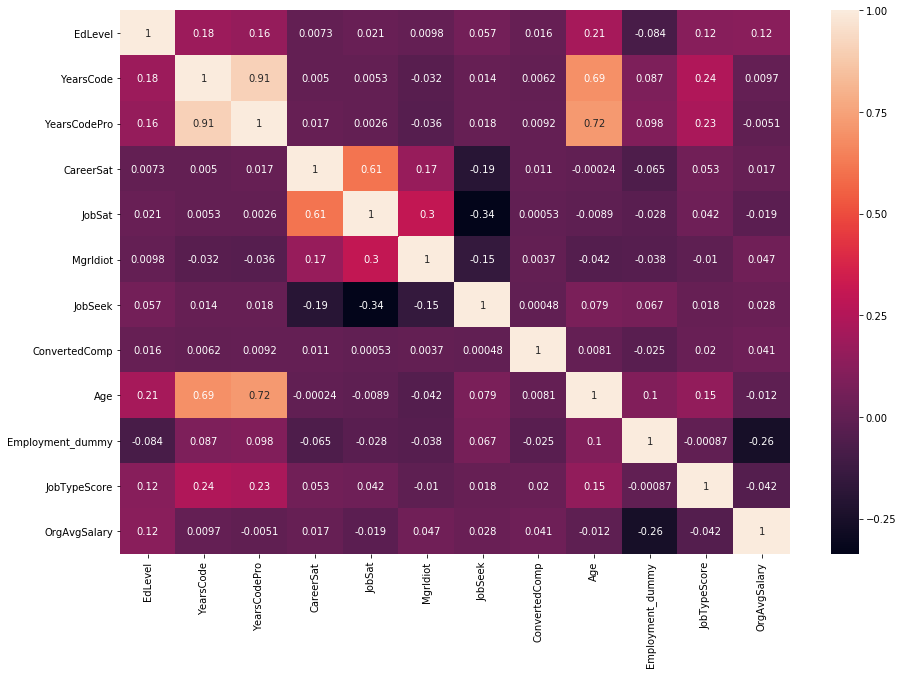

In [35]:
plt.figure(figsize=(15 ,10))
stk_corr = stackoverflow.loc[stackoverflow['Country']=='United States'].convert_objects(convert_numeric=True).corr()
sns.heatmap(stk_corr,
           xticklabels = stk_corr.columns.values,
           yticklabels = stk_corr.columns.values,
           annot = True)

In [36]:
stackoverflow.describe()

,EdLevel,YearsCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,JobSeek,ConvertedComp,Age,Employment_dummy,JobTypeScore,OrgAvgSalary
count,61172.000000,61172.000000,61172.000000,61172.000000,61172.000000,61172.000000,61172.000000,6.117200e+04,61172.000000,61172.000000,61172.000000,61172.000000
mean,0.989521,12.389942,7.773049,3.985484,2.726084,2.195776,0.667103,1.439648e+05,30.834718,1.377052,54.828186,143964.811081
std,0.800254,9.475077,7.915398,1.150614,1.252982,0.812952,0.471254,2.643218e+05,9.510292,0.986680,14.444344,87363.058385
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,23283.594615
25%,0.000000,5.000000,2.000000,4.000000,2.000000,2.000000,0.000000,3.831377e+04,24.000000,1.000000,41.846603,75856.610493
50%,1.000000,10.000000,5.000000,4.000000,3.000000,2.000000,1.000000,8.000000e+04,29.000000,1.000000,61.110880,134959.700538
75%,2.000000,17.000000,10.000000,5.000000,4.000000,3.000000,1.000000,1.450000e+05,35.000000,1.000000,62.406419,240430.402245
max,3.000000,50.000000,50.000000,5.000000,4.000000,3.000000,1.000000,2.000000e+06,99.000000,5.000000,110.536489,273294.838901


## Job Seeking Classfier
#### data preprocessing

In [37]:
quitjob = stackoverflow.copy()

In [38]:
quitjob.columns

Index(['MainBranch', 'OpenSource', 'Employment', 'Country', 'Student',
       'EdLevel', 'UndergradMajor', 'OrgSize', 'DevType', 'YearsCode',
       'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'JobSeek',
       'ConvertedComp', 'Age', 'Gender', 'Employment_dummy', 'JobTypeScore',
       'OrgAvgSalary', 'AgeRange'],
      dtype='object')

### graphs show that people at all EdLevel whose age is in [20,40] are more tend to look for jobs.

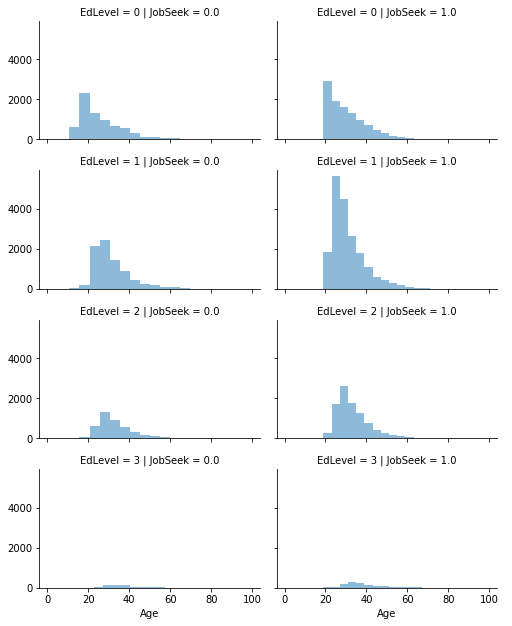

In [39]:
grid = sns.FacetGrid(quitjob, col='JobSeek', row='EdLevel', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

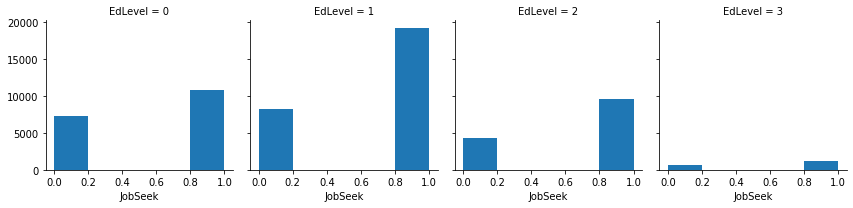

In [40]:
g = sns.FacetGrid(quitjob, col='EdLevel')
g.map(plt.hist, 'JobSeek', bins=5)

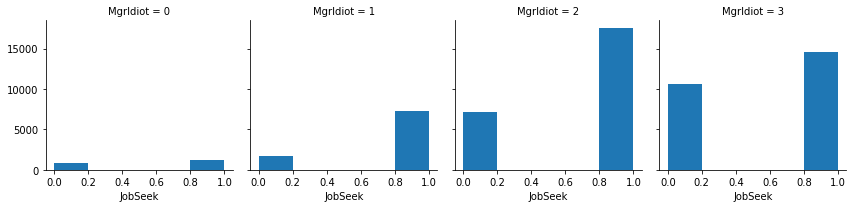

In [41]:
g = sns.FacetGrid(quitjob, col='MgrIdiot')
g.map(plt.hist, 'JobSeek', bins=5)

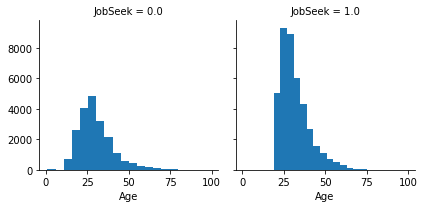

In [42]:
g = sns.FacetGrid(quitjob, col='JobSeek')
g.map(plt.hist, 'Age', bins=20)

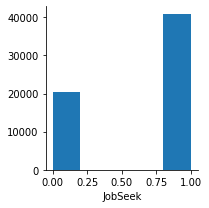

In [43]:
g = sns.FacetGrid(quitjob)
g.map(plt.hist, 'JobSeek', bins=5)

### Get Data ready for modeling

In [44]:
gender_dummy = pd.get_dummies(quitjob['Gender'], drop_first = False)

In [45]:
X = quitjob[['Age', 'JobSat', 'MgrIdiot','EdLevel', 'Employment_dummy','CareerSat']]
y = quitjob['JobSeek']

In [46]:
X = pd.concat([X, gender_dummy], axis = 1, join = 'inner')

In [47]:
X.head()

,Age,JobSat,MgrIdiot,EdLevel,Employment_dummy,CareerSat,LGBTQ,Man,Woman
0,14.0,3,3,0,0,5,0,1,0
3,22.0,3,3,1,1,5,0,1,0
5,28.0,3,3,1,1,5,0,1,0
7,24.0,3,3,1,2,5,0,1,0
9,24.0,1,2,2,1,2,0,1,0


### Build Training and testing set

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

## Decision Tree Model

In [49]:
Classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)
Classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [50]:
y_pred = Classifier.predict(X_test)

In [51]:
print(accuracy_score(y_test, y_pred))

0.7522340889276373


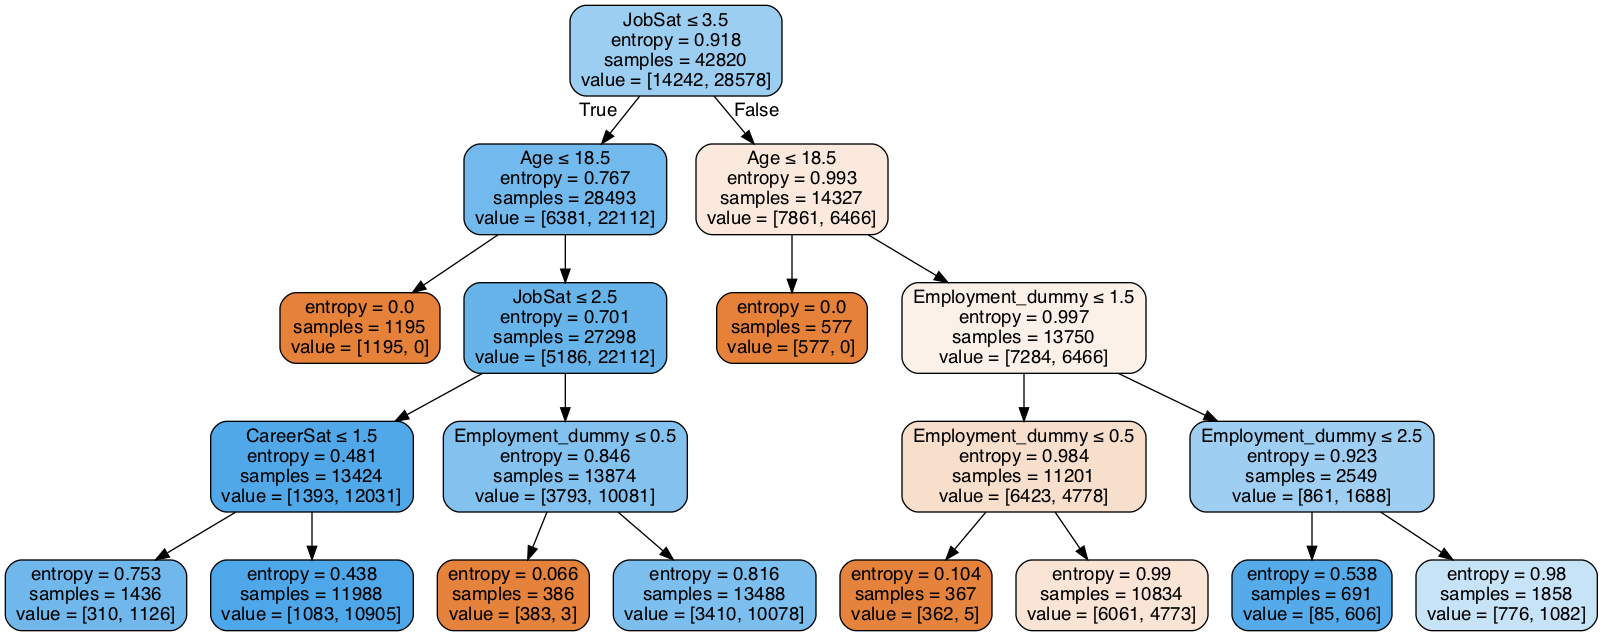

In [52]:
dot_data = StringIO()

export_graphviz(Classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns.tolist())
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [53]:
print(confusion_matrix(y_test, y_pred))

[[ 3628  2494]
 [ 2053 10177]]


## Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)


In [56]:
print(accuracy_score(y_test, y_pred))

0.7316368788142982


### SVM

In [57]:

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)


/Users/hetufeng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [58]:
print(accuracy_score(y_pred, y_test))

0.7537053182214473


## Salary Predictor (US only)

#### Data Preprosessing

In [59]:
salary_df = stackoverflow.copy()

/Users/hetufeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


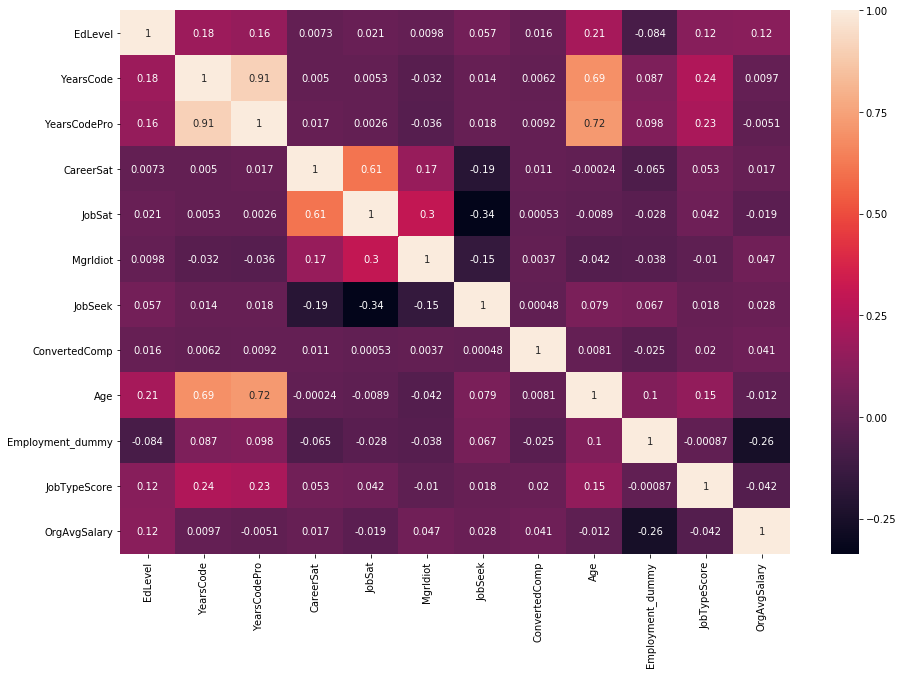

In [60]:
plt.figure(figsize=(15 ,10))
stk_corr = salary_df.loc[salary_df['Country']=='United States'].convert_objects(convert_numeric=True).corr()
sns.heatmap(stk_corr,
           xticklabels = stk_corr.columns.values,
           yticklabels = stk_corr.columns.values,
           annot = True)

#### Model generation and test

### Predict United States

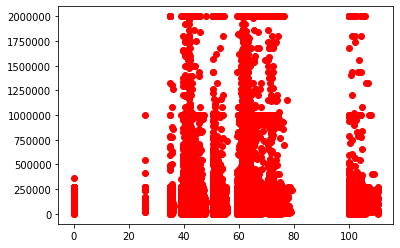

In [61]:
plt.scatter(salary_df['JobTypeScore'], salary_df['ConvertedComp'], color = 'red')

In [62]:
X = salary_df.loc[salary_df['Country'] == 'United States', ['YearsCodePro', 'EdLevel','Age', 'JobTypeScore']]
y = salary_df.loc[salary_df['Country'] == 'United States', 'ConvertedComp']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

### linear regression

In [64]:
from sklearn.linear_model import LinearRegression

In [65]:
reg = LinearRegression()

In [66]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
y_pred = reg.predict(X_test)

In [68]:
reg.score(X_train, y_train)

0.000569426811264151

## Income Level Classfier

In [69]:
salary_df['CompLevel'] = 0
salary_df.loc[(salary_df['ConvertedComp'] <= 200000) &(salary_df['ConvertedComp'] >70000), 'CompLevel'] = 1
salary_df.loc[salary_df['ConvertedComp'] >200000, 'CompLevel'] = 2


In [70]:

# pd.qcut(salary_df['YearsCodePro'],4).unique()
# salary_df.loc[salary_df['YearsCodePro'] <= 2, 'YearsCodePro'] = 0
# salary_df.loc[(salary_df['YearsCodePro'] <= 5) &(salary_df['YearsCodePro'] >2), 'YearsCodePro'] = 1
# salary_df.loc[(salary_df['YearsCodePro'] <= 10) &(salary_df['YearsCodePro'] >5), 'YearsCodePro'] = 2
# salary_df.loc[salary_df['YearsCodePro'] > 10, 'YearsCodePro'] = 3

# pd.qcut(salary_df['JobTypeScore'],4).unique()
# salary_df.loc[salary_df['JobTypeScore'] <= 50, 'JobTypeScore'] = 0
# salary_df.loc[(salary_df['JobTypeScore'] <= 60) &(salary_df['JobTypeScore'] >50), 'JobTypeScore'] = 1
# salary_df.loc[(salary_df['JobTypeScore'] <= 70) &(salary_df['JobTypeScore'] >60), 'JobTypeScore'] = 2
# salary_df.loc[salary_df['JobTypeScore'] > 70, 'JobTypeScore'] = 3


In [71]:
X = salary_df.loc[salary_df['Country'] == 'United States', ['YearsCodePro', 'EdLevel','Age', 'JobTypeScore']]
y = salary_df.loc[salary_df['Country'] == 'United States', 'CompLevel']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [73]:
classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)

In [74]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [75]:
y_pred = classifier.predict(X_test)

In [76]:
print(accuracy_score(y_pred, y_test))

0.5794749403341288


In [77]:
print(confusion_matrix(y_test, y_pred))

[[   0  622  234]
 [   0 2791  177]
 [   1 1609  851]]


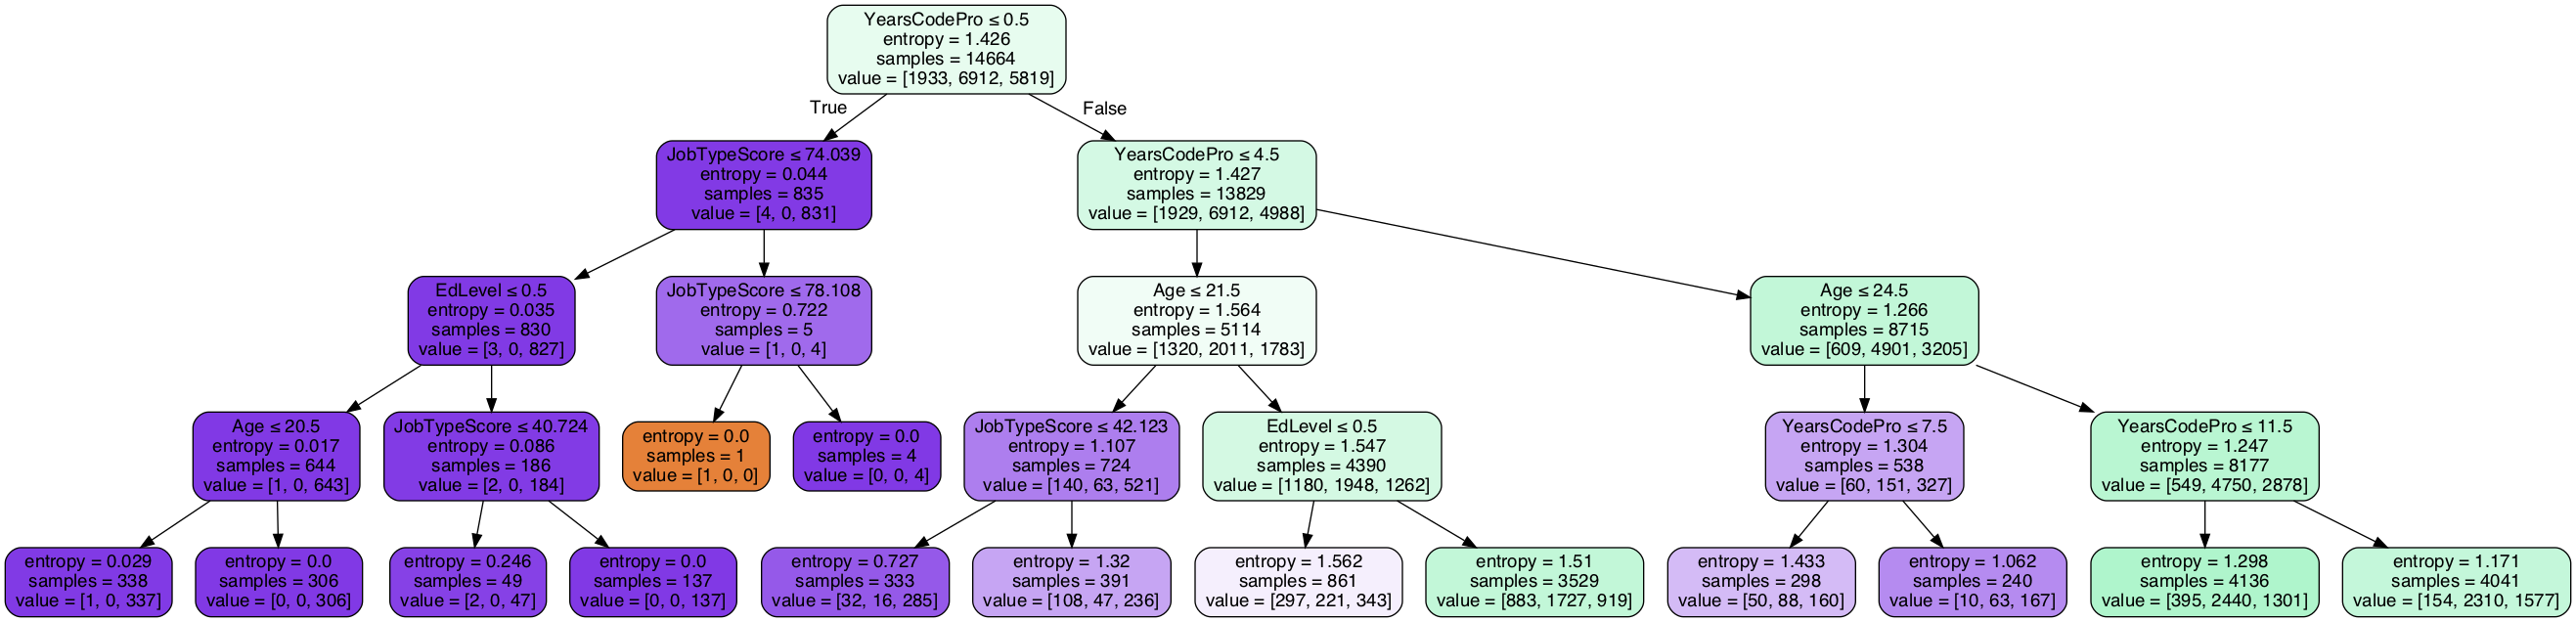

In [78]:
dot_data = StringIO()

export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns.tolist())
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('tree.png')
Image(graph.create_png())

In [79]:
X.head()

,YearsCodePro,EdLevel,Age,JobTypeScore
3,1.0,1,22.0,41.846603
12,8.0,2,28.0,106.034822
21,18.0,0,47.0,64.033790
22,1.0,1,22.0,41.846603
25,8.0,0,34.0,75.167002


### SVC

In [80]:

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)


/Users/hetufeng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [81]:
print(accuracy_score(y_pred, y_test))

0.5891805887032617
